# Microsoft Recommendations

In [1]:
# %run code/add_data.py
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
from pandasql import sqldf
import json
import requests
import os
import seaborn as sns


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


In [2]:
%run code/data_preparations.py
csv_dict.keys()


dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tmdb_genres', 'tmdb_imdb_gross', 'tmdb_imdb_gross_full', 'tmdb_movie_ids', 'tn.movie_budgets'])

In [3]:
#full_profit_df=full_profit_df.query("year > 1990 and year < 2022 & runtime>60")
full_profit_df.head(2)


,id,tconst,title,release_date,revenue,budget,net_profit,year,vote_average,popularity,vote_count,runtime,genre_id
0,5,tt0113101,Four Rooms,1995-12-09,"4,257,354.0","4,000,000.0","257,354.0",1995,5,15,2123,98.0,"[80, 35]"
1,11,tt0076759,Star Wars,1977-05-25,"775,398,007.0","11,000,000.0","764,398,007.0",1977,8,90,16953,121.0,"[12, 28, 878]"


In [4]:
full_profit_by_genre.head(2)

,id,tconst,title,release_date,revenue,budget,net_profit,year,vote_average,popularity,vote_count,runtime,genre_id,genre
0,5,tt0113101,Four Rooms,1995-12-09,"4,257,354.0","4,000,000.0","257,354.0",1995,5,15,2123,98.0,80,Crime
1,93,tt0052561,Anatomy of a Murder,1959-07-01,"8,000,000.0","2,000,000.0","6,000,000.0",1959,7,16,693,161.0,80,Crime


In [5]:

full_profit_vote_df=full_profit_df.query("vote_count>200 & vote_count<20550").copy()
full_profit_vote_df.dropna(subset=["vote_count"], inplace=True)


full_profit_runtime_df=full_profit_df.query("runtime<170 & runtime>60 & revenue<150000000").copy()
full_profit_runtime_df.dropna(subset=["runtime"], inplace=True)
full_profit_runtime_df['length_bin'] = pd.cut(x=full_profit_runtime_df['runtime'], bins=list(range(60,170,8)))
runtime_summary_df=full_profit_runtime_df.groupby('length_bin', as_index=False).mean()[['length_bin','revenue']]


full_profit_avgvote_df=full_profit_df.query("vote_average>0").copy()
full_profit_avgvote_df.dropna(subset=["vote_average"], inplace=True)

full_profit_pop_df=full_profit_df.query("(popularity<220 & popularity>0) & revenue<1500000000").copy()
full_profit_pop_df.dropna(subset=["popularity"], inplace=True)

dir_summary_all_df=full_profit_dir_df.groupby(["primary_name"],as_index=False).mean().sort_values(by="revenue", ascending=False)[['primary_name','revenue']]
promising_dir_df=(full_profit_dir_df["primary_name"].value_counts().sort_values(ascending=False)>3).reset_index()
dir_summary_df=dir_summary_all_df.merge(promising_dir_df, left_on=['primary_name'], right_on=['index'])

dir_summary_df=dir_summary_df.loc[dir_summary_df.primary_name_y==True,:]





In [6]:
None

In [26]:
full_profit_df=full_profit_df.query("year > 1991 and year < 2022 & runtime>60").copy()
genre_summary_df=full_profit_by_genre.groupby(['genre'], as_index=False).mean().sort_values(by="revenue", ascending=False)[['genre','revenue']]

full_profit_year_df=full_profit_df.query("year > 1991 and year < 2022").copy()
year_summary_df=full_profit_year_df.groupby(['year'], as_index=False).sum().sort_values(by="year")[['year','revenue']]
year_summary_df=year_summary_df.query("year > 1991 and year < 2022").copy()
year_summary_df.head()

full_profit_df["year"]=full_profit_df["year"].astype(int)



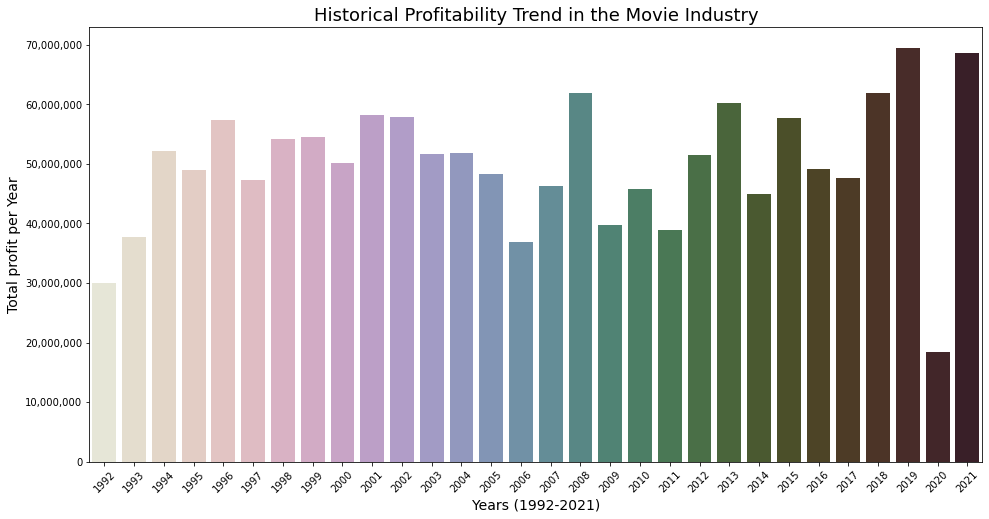

In [25]:
fig,ax=plt.subplots(  figsize=(16,8))

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.barplot(x='year', y='revenue', data=year_summary_df, ax=ax, palette="ch:r=1.65,l=.9" );

#ax.set_ylim(min(year_summary_df['revenue'])-15000000, max(year_summary_df['revenue'])+15000000);
num_of_ticks=list(range(len(year_summary_df)))
ax.set_xticks(num_of_ticks);
ax.set_xticklabels(list(year_summary_df['year']),  rotation=45);

ax.set_title("Historical Profitability Trend in the Movie Industry", fontsize=18 )
ax.set_ylabel("Total profit per Year", fontsize=14)
ax.set_xlabel("Years (1992-2021)", fontsize=14);

fig.savefig('images/profit_by_year.png')

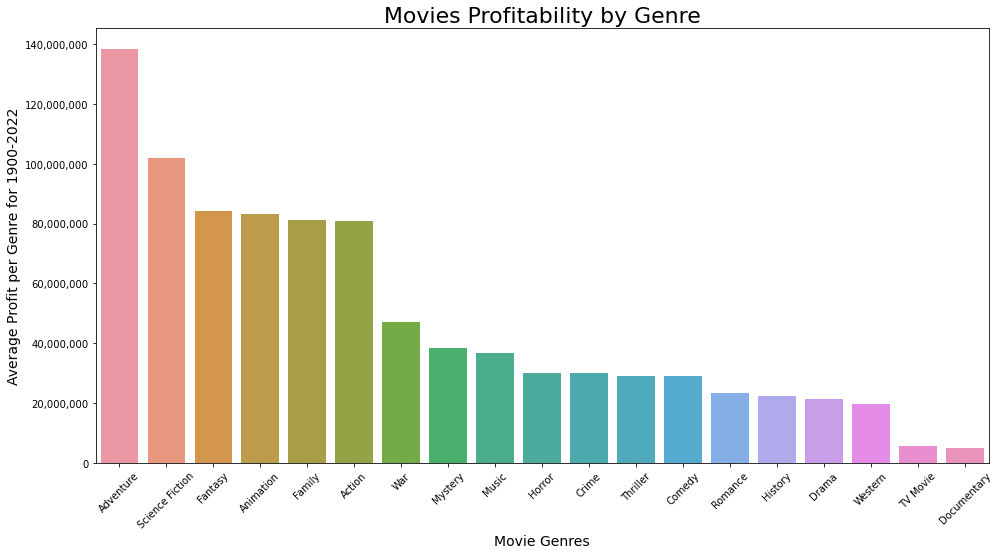

In [9]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)


fig,ax=plt.subplots(  figsize=(16,8))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.barplot(x='genre', y='revenue', data=genre_summary_df, ax=ax);

num_of_ticks=list(range(len(genre_summary_df['genre'])))
ax.set_xticks(num_of_ticks);
ax.set_xticklabels(list(genre_summary_df['genre']),  rotation=45);
ax.set_title("Movies Profitability by Genre", fontsize=22 )
ax.set_ylabel("Average Profit per Genre for 1900-2022", fontsize=14)
ax.set_xlabel("Movie Genres", fontsize=14);


fig.savefig('images/profit_by_genre.png')

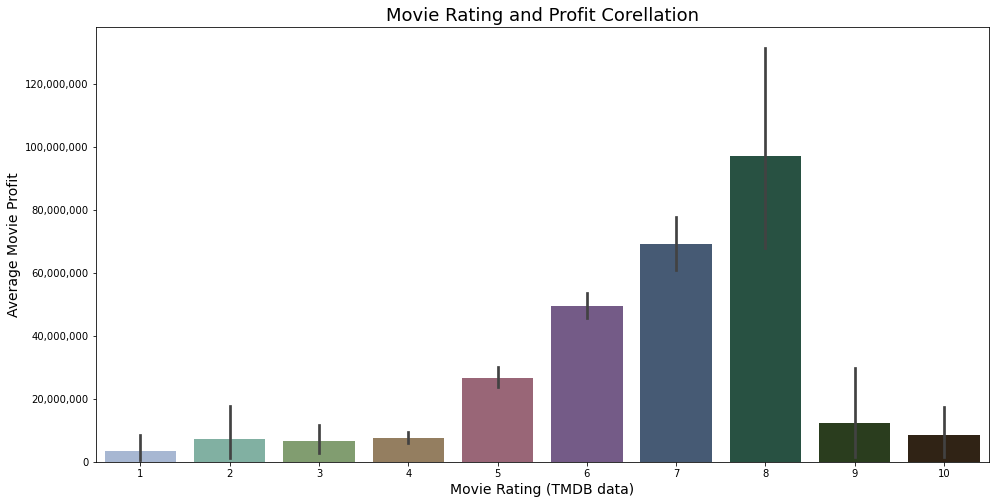

In [10]:

fig,ax=plt.subplots( figsize=(16,8))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

pd.set_option('display.float_format', lambda x: '%.7f' % x)

sns.barplot(x='vote_average', y='revenue', data=full_profit_avgvote_df, ax=ax, palette="ch:r=2.75,l=.7");


ax.set_title("Movie Rating and Profit Corellation", fontsize=18 )
ax.set_ylabel("Average Movie Profit", fontsize=14 )
ax.set_xlabel("Movie Rating (TMDB data)", fontsize=14 );

fig.savefig('images/avg_rating_correlations.png')



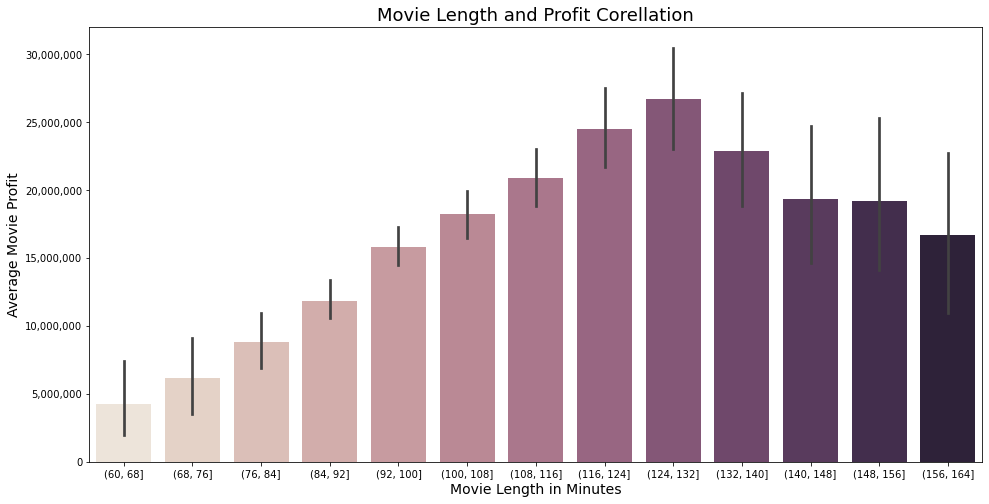

In [11]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
fig,ax=plt.subplots(  figsize=(16,8))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.barplot(x='length_bin', y='revenue', data=full_profit_runtime_df, ax=ax, palette="ch:r=.45,l=.9");

ax.set_title("Movie Length and Profit Corellation", fontsize=18 )
ax.set_ylabel("Average Movie Profit", fontsize=14 )
ax.set_xlabel("Movie Length in Minutes", fontsize=14 );

fig.savefig('images/optimal_movie_length.png')



In [12]:
#fig,ax=plt.subplots( figsize=(16,8))
#ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#sns.scatterplot(x='popularity', y='revenue', data=full_profit_pop_df, ax=ax);
#sns.regplot(x='popularity', y='revenue', color='red', data=full_profit_pop_df);



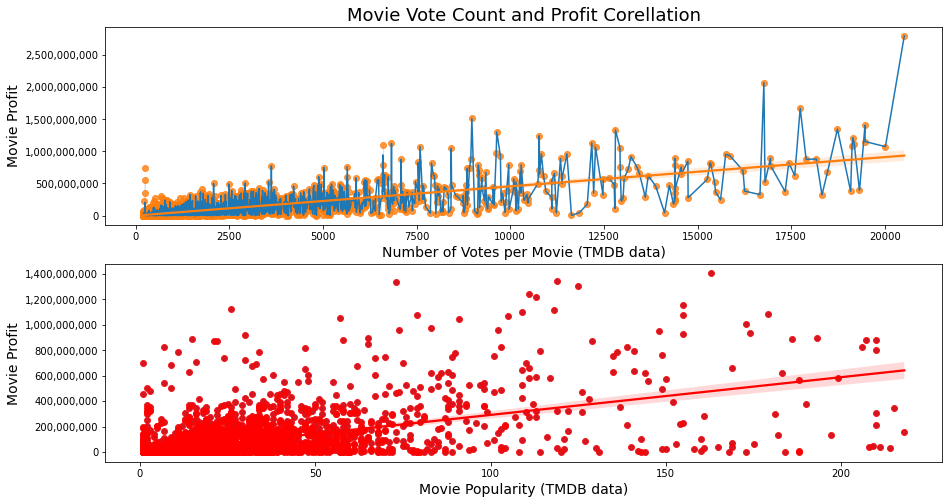

In [13]:

fig,ax=plt.subplots( nrows=2, figsize=(15,8))

pd.set_option('display.float_format', lambda x: '%.7f' % x)
ax[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


num_of_ticks=list(range(len(genre_summary_df['genre'])))

sns.lineplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax[0]);
sns.regplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax[0]);


sns.scatterplot(x='popularity', y='revenue', data=full_profit_pop_df, ax=ax[1]);
sns.regplot(x='popularity', y='revenue', color='red', data=full_profit_pop_df, ax=ax[1]);


ax[0].set_title("Movie Vote Count and Profit Corellation", fontsize=18 )
#ax[1].set_title("Movie Popularity and Profit Corellation", fontsize=18 )

ax[0].set_ylabel("Movie Profit", fontsize=14 )
ax[1].set_ylabel("Movie Profit", fontsize=14 )

ax[0].set_xlabel("Number of Votes per Movie (TMDB data)", fontsize=14 )
ax[1].set_xlabel("Movie Popularity (TMDB data)", fontsize=14 )



fig.savefig('images/misc_profit_correlations.png')



In [14]:
#fig,ax=plt.subplots(  figsize=(16,8))
#ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


#sns.barplot(x='primary_name_x', y='revenue', data=dir_summary_df, ax=ax);
#dir_num=list(dir_summary_df["primary_name_x"])

#num_of_dir=list(range(len(dir_summary_df['primary_name_x'])))
#ax.set_xticks(num_of_dir);
#ax.set_xticklabels(list(dir_summary_df["primary_name_x"]),  rotation=45);

In [15]:
#fig,ax=plt.subplots(  figsize=(16,8))
#ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#full_profit_pop_df=full_profit_df.query("popularity>20 and popularity<110")

#full_profit_pop_df=full_profit_df.query("popularity>20 and popularity<110")
#sns.lineplot(x='vote_count', y='revenue', data=full_profit_pop_df, ax=ax);

#sns.lineplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax);
#sns.regplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax);